# Visual Odometry

* Estimation of the pose of the camera based on the motion information of the consecutive images. 
* Computes camera path incrementally - Pose after pose 
* Visual odometry works as detecting, tracking the feature maps of each of the frames and tracking them into consecutive frames. 
* VSLAM is also a kind of visual odometry with having some extra attributes such as loop closure and global optimization.

    * Image sequence ==> Feature Detection ==> Feature Matching & Tracking ==> Motion Estimation ==> Local Optimization
    
* Actual engineering behind the Feature matching and tracking is based on the projection. The solution can be seen as determination of transformation that minimizes reprojection error of the triangulated point each image.
* Triangulation is the process of measuring the same feature movement in the another frames. 
* This can be done using Essential Matrix.

## Fundamental and Essential Matrix
* Essential Matrix is a matrix related to stereo camera's corresponding points assuming that the camera satisfy the pinhole camera model for calibrated camera.
* Fundamental matrix is used for uncalibrated camera.
* These matrix contains the all information about the relative orientation from corrosponding points.
* Both matrices are homogenius matrix 3x3 having ranks of 2. 
* The rank fo these matrix used for formulaiting "Coplanarity constraint" as

&nbsp; $ x'^{T} F x''=0 $ &nbsp;where x' is the points of image 1, x'' are the points in the image 2 and F is Coplanarity constraint.

* Considering F or E as unknown, we can build sstem of linear equation and come up with homogeneous system.
* Coplanarity constraint of observed points lead to $ Af=0$ &nbsp; that can be solved through SVD.
* This can be done using 8-point algorithm (given 8 points, we can estimate F).
* Once we have F or E, then we can decompose into B (Baseline vector) and R (Rotation matrix which can tell us how camera 2 oriented with respect to camera 1.
* We can locate whete camera 2 is w.r.t. camera 1 but cant identify how far it is => Scale ambiguity.
* Knowing F or E, substantially helps us to reduce the our search for corrosponding point in the other image.
* E matrix have 5-DoF and F-matrix have 7-DoF (It contains calbration parameters information too). 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

C:\Users\eight\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\eight\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\eight\anaconda3\lib\site-packages\numpy\.libs\libopenblas.wcdjnk7yvmpzq2me2zzhjjrj3jikndb7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:\n%s" %


In [82]:
import cv2

from utils import *
from m2bk import *

In [3]:
def dataloader():
    pass

## Feature extraction from image
#### Fetures
+ Point of interests in an image
+ Can be found on multiple images

### Feature Detection algorithms
+ Harris (corners) {Harris & Stephans, 1988} - Easy to compute, not scale Invariant
+ Harris-laplass (corners) - Scale selection is based on Laplacian
+ FAST (Features from Accelirated Segment Test, 2006) - ML based fast corner detection algorithm

### Image Features Descriptors
     Descriptor : 
        * N-Dim vector that provide summery of the image information arround the detected frame
        * Invariance to tranformation( Rotation, Translation, scaling)
        * Distinetiveness : We can able to destinguish between two close by features

#### SIFT (Scale Invariant feature Transformer) {1999}
+ 16x16 window around detected frame 
    * Separated into 4 cells -Each comprassed of 4x4 patch of pixel
    * Compute edge orientation of each pixel in the cell
    * Supress edges according to predefined threshold
    * Construct 32-dim histogram of orientation for each cell and then concatenate -> 128 dim descriptor
  
#### Other algorithms
* ORB (Oriented Fast and Rotated Brief)
* SURF (Speeded Up Robust Features)
* BRIEF (Binary Robust Independent Elementary Features)
* GLOH (Gradient Location Orientation Histogram)




In [11]:
def feature_extractor(img,flag):
    if flag=='SIFT':
        sift=cv2.SIFT_create(500)
        kp,des=sift.detectAndCompute(img, None)
        return kp,des
    if flag=='ORB':
        orb=cv2.ORB_create(500)
        kp,des=orb.detectAndCompute(img,None)
        return kp,des

In [12]:
def feature_extraction_dataset(imgs, feature_extractor,flag='SIFT'):
    kp_list=[]
    des_list=[]
    for img in imgs:
        kp,des=feature_extractor(img,flag)
        kp_list.append(kp)
        des_list.append(des)
    return kp_list, des_list
        

In [13]:
img=cv2.imread('kitty.jpg')
img=cv2.resize(img,(int(img.shape[1]/2.5),int(img.shape[0]/2.5)))

In [14]:
img.shape

(1203, 1644, 3)

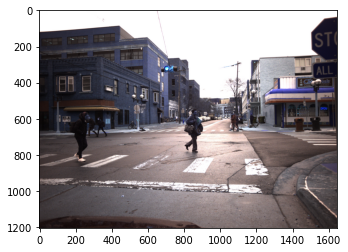

In [15]:
plt.imshow(img)

In [16]:
kp,des=feature_extractor(img,'SIFT')

In [21]:
display=cv2.drawKeypoints(img,kp,None,(255,0,0),10)

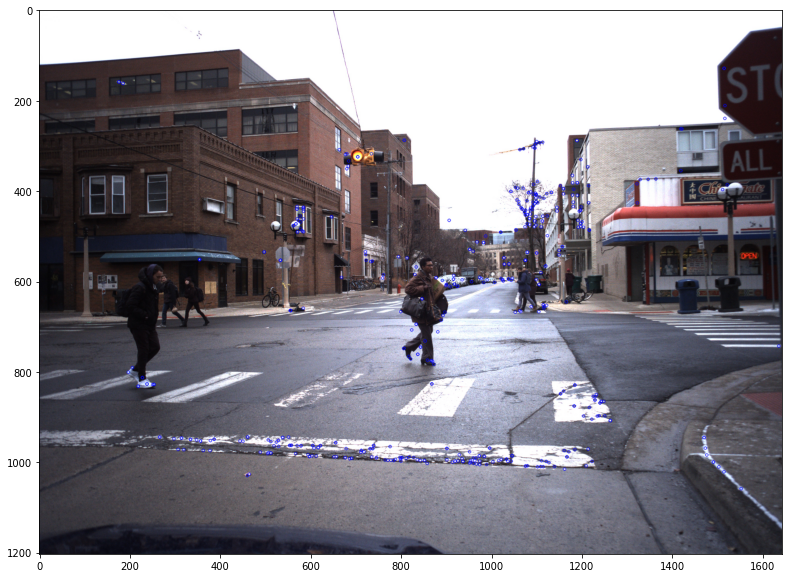

In [67]:
plt.figure(figsize = (20,10))
plt.imshow(cv2.cvtColor(display,cv2.COLOR_BGR2RGB))

In [199]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

In [200]:
folder="C:/Users/eight/Documents/cv lab/Untitled Folder/data/rgb/"

In [201]:
%%time
images_=load_images_from_folder(folder)

Wall time: 1.93 s


In [202]:
len(images_)

52

In [203]:
%%time
kp_list,des_list=feature_extraction_dataset(images_,feature_extractor)

Wall time: 22.5 s


In [204]:
len(kp_list)

52

In [205]:
len(des_list)

52

In [206]:
len(images_)

52

## Feature matching
* Brute-Force Matching algorithm
* FLANN Matching algorithma

In [207]:
def BF_matcher(des1,des2):
    bf=cv2.BFMatcher(cv2.NORM_HAMMING,crossCheck=True)
    match=bf.knnMatch(np.asarray(des1,np.float32),np.asarray(des2,np.float32),k=2)
    return match

In [208]:
def Flann_matcher(des1,des2):
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)

    flann = cv2.FlannBasedMatcher(index_params,search_params)
    matches = flann.knnMatch(des1,des2,k=2)
    return matches

In [209]:
kp1,des1=feature_extractor(images_[1],'SIFT')
kp2,des2=feature_extractor(images_[2],'SIFT')

In [210]:
matches=Flann_matcher(des1,des2)

In [211]:
img1=images_[1]
img2=images_[2]

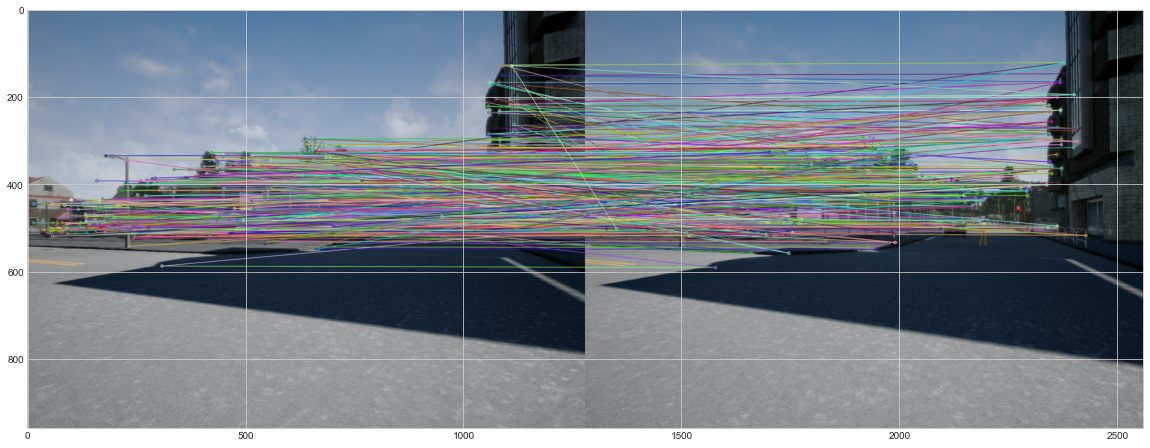

In [212]:
img3=cv2.drawMatchesKnn(img1,kp1,img2,kp2,matches,None,flags=2)
plt.figure(figsize = (20,10))
plt.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))
plt.show()

In [213]:
def filter_matches_distance(match, dist_threshold):
    """
    Filter matched features from two images by distance between the best matches

    Arguments:
    match -- list of matched features from two images
    dist_threshold -- maximum allowed relative distance between the best matches, (0.0, 1.0) 

    Returns:
    filtered_match -- list of good matches, satisfying the distance threshold
    """
    filtered_match = []
    
    ### START CODE HERE ###
    for i,(m,n) in enumerate(match):
        if m.distance < dist_threshold*n.distance:
            filtered_match.append(m)
        

    
    ### END CODE HERE ###
    print('filtered_matches: ',len(filtered_match))
    return filtered_match

In [214]:
# Optional
i = 0 
des1 = des_list[i]
des2 = des_list[i+1]
match = Flann_matcher(des1, des2)

dist_threshold = 0.6
filtered_match = filter_matches_distance(match, dist_threshold)

print("Number of features matched in frames {0} and {1} after filtering by distance: {2}".format(i, i+1, len(filtered_match)))

filtered_matches:  206
Number of features matched in frames 0 and 1 after filtering by distance: 206


In [215]:
type(match)

tuple

In [216]:
for l,m in match:
    print(l)
    print(m)
    break

<DMatch 0000007EAF7BC550>
<DMatch 0000007EADD32070>


In [217]:
def visualize_matches(image1, kp1, image2, kp2, match):
    """
    Visualize corresponding matches in two images

    Arguments:
    image1 -- the first image in a matched image pair
    kp1 -- list of the keypoints in the first image
    image2 -- the second image in a matched image pair
    kp2 -- list of the keypoints in the second image
    match -- list of matched features from the pair of images

    Returns:
    image_matches -- an image showing the corresponding matches on both image1 and image2 or None if you don't use this function
    """
    image_matches = cv2.drawMatches(image1,kp1,image2,kp2,filtered_match[:50],None,flags=2)
    print('filtered_matches: ',len(filtered_match[:50]))
    plt.figure(figsize=(16, 6), dpi=100)
    plt.imshow(cv2.cvtColor(image_matches, cv2.COLOR_BGR2RGB))

filtered_matches:  50


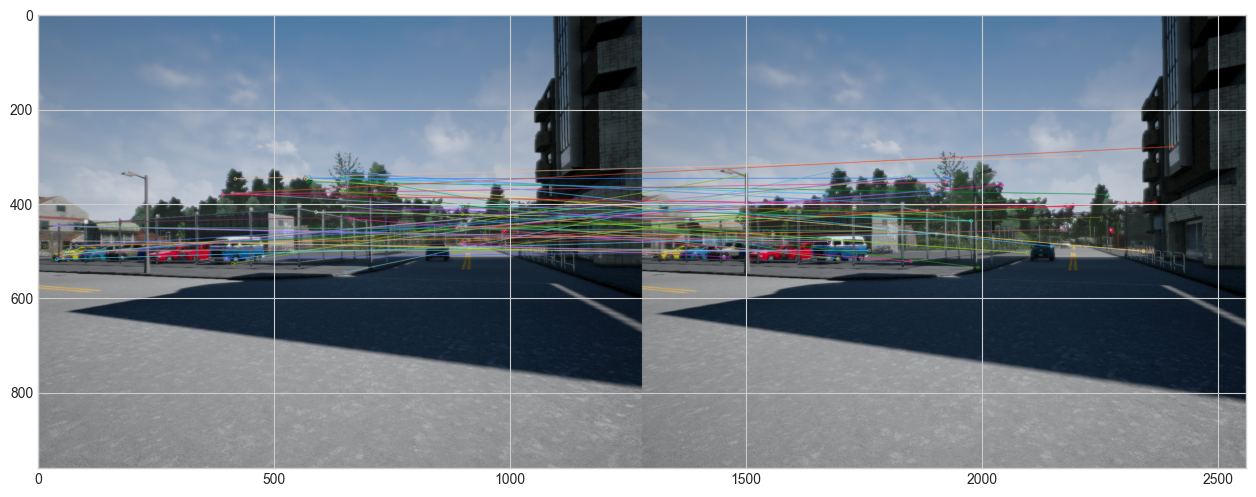

In [218]:
# Visualize n first matches, set n to None to view all matches
# set filtering to True if using match filtering, otherwise set to False
n = 10
filtering = False

i = 0 
image1 = images_[1]
image2 = images_[2]

kp1 = kp_list[1]
kp2 = kp_list[2]

des1 = des_list[1]
des2 = des_list[2]

match = Flann_matcher(des1, des2)
if filtering:
    dist_threshold = 0.9
    match = filter_matches_distance(match, dist_threshold)

image_matches = visualize_matches(image1, kp1, image2, kp2, match[:n]) 

In [219]:
def match_features_dataset(des_list, match_features):
    """
    Match features for each subsequent image pair in the dataset

    Arguments:
    des_list -- a list of descriptors for each image in the dataset
    match_features -- a function which maches features between a pair of images

    Returns:
    matches -- list of matches for each subsequent image pair in the dataset. 
               Each matches[i] is a list of matched features from images i and i + 1
               
    """
    matches = []
    
    ### START CODE HERE ###
    for i in range(len(des_list)-1):
        descriptor1 = des_list[i]
        descriptor2 = des_list[i+1]
        match = Flann_matcher(descriptor1, descriptor2)
        matches.append(match)
    ### END CODE HERE ###
    
    return matches

In [220]:
matches = match_features_dataset(des_list, Flann_matcher)

i = 0
print("Number of features matched in frames {0} and {1}: {2}".format(i, i+1, len(matches[i])))

Number of features matched in frames 0 and 1: 500


In [221]:
# Optional
def filter_matches_dataset(filter_matches_distance, matches, dist_threshold):
    """
    Filter matched features by distance for each subsequent image pair in the dataset

    Arguments:
    filter_matches_distance -- a function which filters matched features from two images by distance between the best matches
    matches -- list of matches for each subsequent image pair in the dataset. 
               Each matches[i] is a list of matched features from images i and i + 1
    dist_threshold -- maximum allowed relative distance between the best matches, (0.0, 1.0) 

    Returns:
    filtered_matches -- list of good matches for each subsequent image pair in the dataset. 
                        Each matches[i] is a list of good matches, satisfying the distance threshold
               
    """
    filtered_matches = []
    
    ### START CODE HERE ###
    for m in matches:
        new_match=filter_matches_distance(m,dist_threshold)
        filtered_matches.append(new_match)


    
    ### END CODE HERE ###
    
    return filtered_matches

In [222]:
%%time
# Optional
dist_threshold = 0.6

filtered_matches = filter_matches_dataset(filter_matches_distance, matches, dist_threshold)

if len(filtered_matches) > 0:
    
    # Make sure that this variable is set to True if you want to use filtered matches further in your assignment
    is_main_filtered_m = False
    if is_main_filtered_m: 
        matches = filtered_matches

    i = 0
    print("Number of filtered matches in frames {0} and {1}: {2}".format(i, i+1, len(filtered_matches[i])))

filtered_matches:  206
filtered_matches:  213
filtered_matches:  193
filtered_matches:  189
filtered_matches:  201
filtered_matches:  191
filtered_matches:  186
filtered_matches:  171
filtered_matches:  192
filtered_matches:  205
filtered_matches:  180
filtered_matches:  184
filtered_matches:  181
filtered_matches:  152
filtered_matches:  175
filtered_matches:  179
filtered_matches:  157
filtered_matches:  173
filtered_matches:  181
filtered_matches:  167
filtered_matches:  157
filtered_matches:  189
filtered_matches:  164
filtered_matches:  173
filtered_matches:  175
filtered_matches:  166
filtered_matches:  135
filtered_matches:  151
filtered_matches:  140
filtered_matches:  138
filtered_matches:  135
filtered_matches:  144
filtered_matches:  141
filtered_matches:  125
filtered_matches:  128
filtered_matches:  154
filtered_matches:  140
filtered_matches:  125
filtered_matches:  135
filtered_matches:  130
filtered_matches:  133
filtered_matches:  125
filtered_matches:  143
filtered_ma

## Trajectory Estimation

Visual Odemetry : Estimating change in the position of the camera over time


#### Motion estimation algorithms
* Perspective-n-Point (PnP)
* Essential Matirx Decomposition : Geometric relations of image pairs used for calibrated camera
           

In [224]:
count=0
for l, m in match:
    print(m.trainIdx)
    print(m.queryIdx)
    print(m.distance)
    print(m.imgIdx)
    print(l.trainIdx)
    print(l.queryIdx)
    print(l.distance)
    print(l.imgIdx)
    #p1x,p1y=kp1[query_idx].pt
    count=count+1
    if count==2:
        break

124
0
336.7550964355469
0
407
0
248.0181427001953
0
271
1
262.7470397949219
0
496
1
255.74205017089844
0


In [225]:
def estimate_motion(match, kp1, kp2, k, depth1=None):
    """
    Estimate camera motion from a pair of subsequent image frames

    Arguments:
    match -- list of matched features from the pair of images
    kp1 -- list of the keypoints in the first image
    kp2 -- list of the keypoints in the second image
    k -- camera calibration matrix 
    
    Optional arguments:
    depth1 -- a depth map of the first frame. This argument is not needed if you use Essential Matrix Decomposition

    Returns:
    rmat -- recovered 3x3 rotation numpy matrix
    tvec -- recovered 3x1 translation numpy vector
    image1_points -- a list of selected match coordinates in the first image. image1_points[i] = [u, v], where u and v are 
                     coordinates of the i-th match in the image coordinate system
    image2_points -- a list of selected match coordinates in the second image. image1_points[i] = [u, v], where u and v are 
                     coordinates of the i-th match in the image coordinate system
               
    """
    
    r_matrix=np.eye(3)
    t_vector=np.zeros((3,1))
    img1_points=[]
    img2_points=[]
    
    for l,m in match:
        train_idx=m.trainIdx
        query_idx=m.queryIdx
        p1x,p1y=kp1[query_idx].pt
        img1_points.append([p1x,p1y])
        
        p2x,p2y=kp2[train_idx].pt
        img2_points.append([p2x,p2y])
    E,mask=cv2.findEssentialMat(np.array(img1_points),np.array(img2_points),k)
    
    points,r_matrix,t_vector,mask=cv2.recoverPose(E,np.array(img1_points),np.array(img2_points),k)
    
    return r_matrix,t_vector,img1_points,img2_points

In [158]:
dataset_handler = DatasetHandler()

KeyboardInterrupt: 

In [226]:
k = np.array([[640, 0, 640],[0, 480, 480],[0,   0,   1]], dtype=np.float32)

In [227]:
%%time
i = 0
match = matches[i]
kp1 = kp_list[i]
kp2 = kp_list[i+1]
#k = m2bk.DatasetHandler().k
#depth = dataset_handler.depth_maps[i]

rmat, tvec, image1_points, image2_points = estimate_motion(match, kp1, kp2, k)

print("Estimated rotation:\n {0}".format(rmat))
print("Estimated translation:\n {0}".format(tvec))

Estimated rotation:
 [[ 0.98317174  0.13493669  0.12314796]
 [-0.12818751  0.98985918 -0.06121084]
 [-0.13015873  0.04439474  0.99049877]]
Estimated translation:
 [[-0.49723523]
 [ 0.03868499]
 [ 0.8667529 ]]
Wall time: 438 ms


**Camera Movement Visualization**:
You can use `visualize_camera_movement` that is provided to you. This function visualizes final image matches from an image pair connected with an arrow corresponding to direction of camera movement (when `is_show_img_after_mov = False`). The function description:
```
Arguments:
image1 -- the first image in a matched image pair (RGB or grayscale)
image1_points -- a list of selected match coordinates in the first image. image1_points[i] = [x, y], where x and y are 
                 coordinates of the i-th match in the image coordinate system
image2 -- the second image in a matched image pair (RGB or grayscale)
image2_points -- a list of selected match coordinates in the second image. image1_points[i] = [x, y], where x and y are 
                 coordinates of the i-th match in the image coordinate system
is_show_img_after_mov -- a boolean variable, controling the output (read image_move description for more info) 

Returns:
image_move -- an image with the visualization. When is_show_img_after_mov=False then the image points from both images are visualized on the first image. Otherwise, the image points from the second image only are visualized on the second image
```

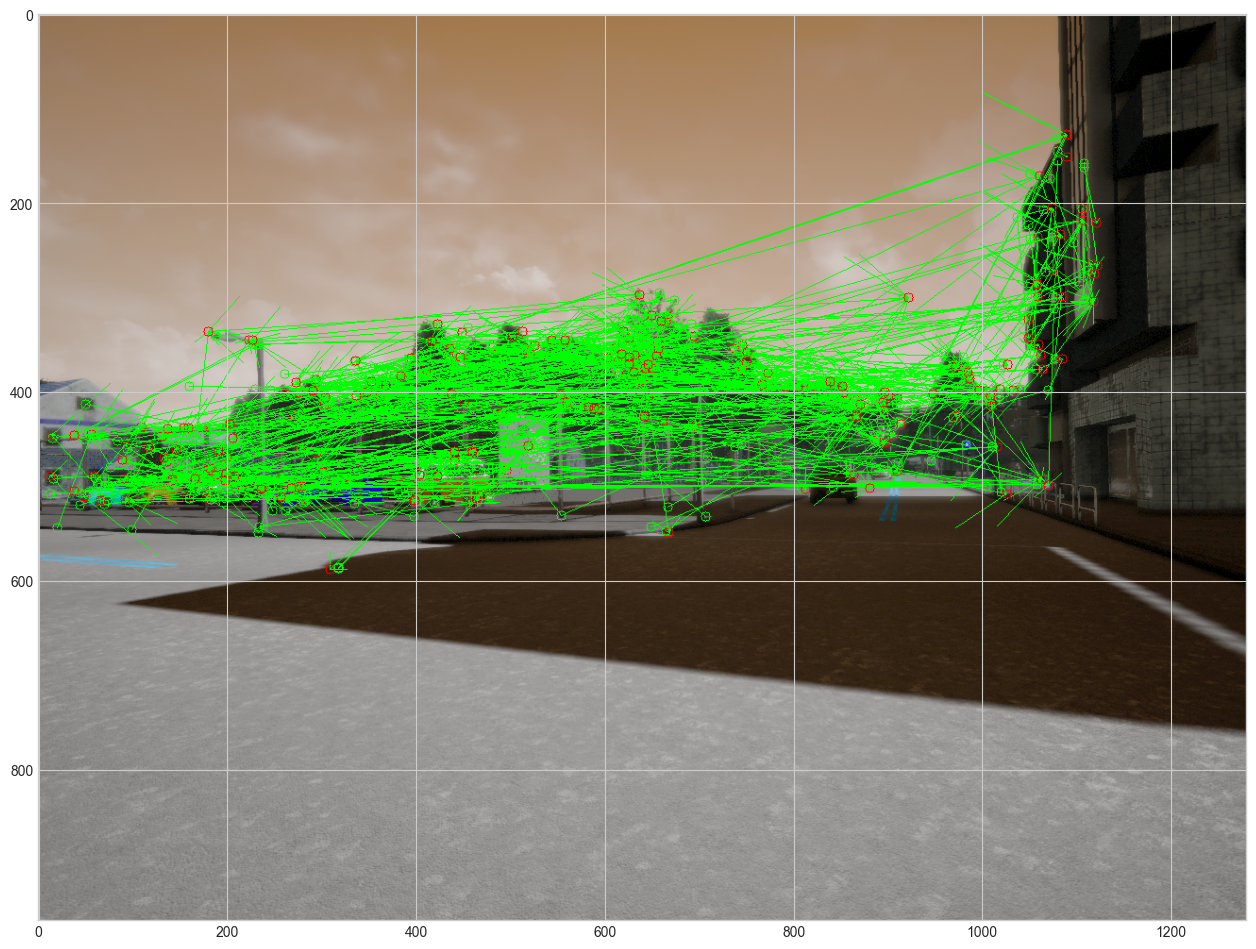

In [228]:
i=0
image1  = images_[0]
image2 = images_[1]

image_move = visualize_camera_movement(image1, image1_points, image2, image2_points)
plt.figure(figsize=(16, 12), dpi=100)
plt.imshow(image_move)

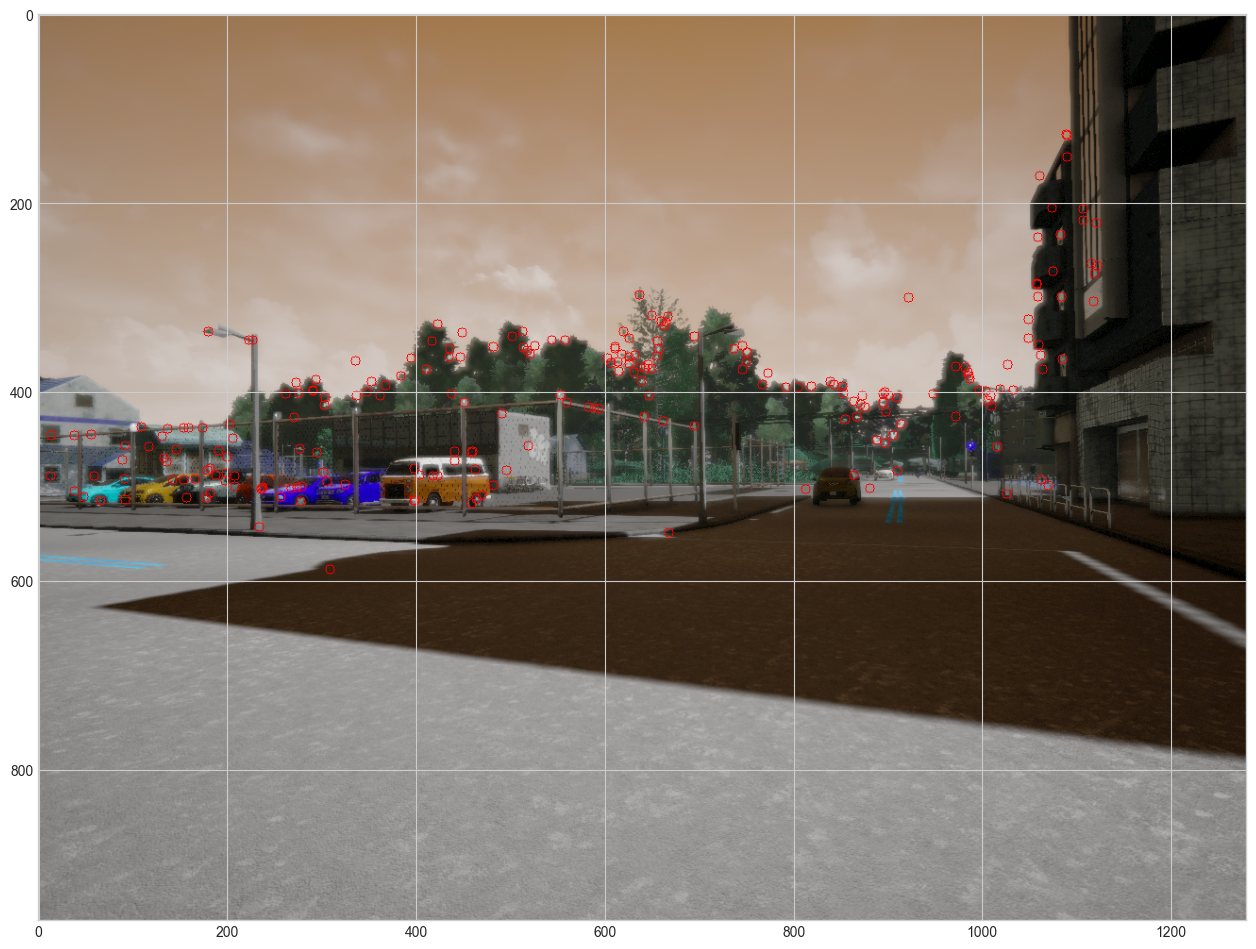

In [229]:
image_move = visualize_camera_movement(image1, image1_points, image2, image2_points, is_show_img_after_move=True)
plt.figure(figsize=(16, 12), dpi=100)
plt.imshow(image_move)
# These visualizations might be helpful for understanding the quality of image points selected for the camera motion estimation

In [230]:
range(len(matches))

range(0, 51)

In [231]:
match = matches[0]
kp1 = kp_list[0]
kp2 = kp_list[1]

In [232]:
print(len(matches))
print(len(kp_list))
#print(len(kp2_list))

51
52


In [233]:
rmat,tvec,img1_points,img2_points=estimate_motion(match,kp1,kp2,k)

## Camera Trajectory Estimation

In [234]:
def estimate_trajectory(estimate_motion, matches, kp_list, k, depth_maps=None):
    """
    Estimate complete camera trajectory from subsequent image pairs

    Arguments:
    estimate_motion -- a function which estimates camera motion from a pair of subsequent image frames
    matches -- list of matches for each subsequent image pair in the dataset. 
               Each matches[i] is a list of matched features from images i and i + 1
    des_list -- a list of keypoints for each image in the dataset
    k -- camera calibration matrix 
    
    Optional arguments:
    depth_maps -- a list of depth maps for each frame. This argument is not needed if you use Essential Matrix Decomposition

    Returns:
    trajectory -- a 3xlen numpy array of the camera locations, where len is the lenght of the list of images and   
                  trajectory[:, i] is a 3x1 numpy vector, such as:
                  
                  trajectory[:, i][0] - is X coordinate of the i-th location
                  trajectory[:, i][1] - is Y coordinate of the i-th location
                  trajectory[:, i][2] - is Z coordinate of the i-th location
                  
                  * Consider that the origin of your trajectory cordinate system is located at the camera position 
                  when the first image (the one with index 0) was taken. The first camera location (index = 0) is geven 
                  at the initialization of this function

    """
    
    trajectory= [np.array([0,0,0])]
    R=np.diag([1,1,1])
    T=np.zeros([3,1])
    RT=np.hstack([R,T])
    RT=np.vstack([RT,np.zeros([1,4])])
    RT[-1,-1]=1
    
    for i in range(len(matches)):
        match=matches[i]
        kp1=kp_list[i]
        kp2=kp_list[i+1]
        rmat,tvec,img1_points,img2_points=estimate_motion(match,kp1,kp2,k)
        rt_mat=np.hstack([rmat,tvec])
        rt_mat=np.vstack([rt_mat,np.zeros([1,4])])
        rt_mat[-1,-1]=1
        
        # https://docs.opencv.org/3.4.3/d9/dab/tutorial_homography.html
        rt_mat_inv=np.linalg.inv(rt_mat)
        RT=np.dot(RT,rt_mat_inv)
        new_traj=RT[:3,3]
        
        trajectory.append(new_traj)
    trajectory=np.array(trajectory).T
    
    return trajectory
        
      
    

In [235]:
%%time
#depth_maps = dataset_handler.depth_maps
trajectory = estimate_trajectory(estimate_motion, matches, kp_list, k)
print(type(trajectory))
i = 1
print("Camera location in point {0} is: \n {1}\n".format(i, trajectory[:, [i]]))

# Remember that the length of the returned by trajectory should be the same as the length of the image array
print("Length of trajectory: {0}".format(trajectory.shape[1]))

<class 'numpy.ndarray'>
Camera location in point 1 is: 
 [[ 0.60664202]
 [-0.00967668]
 [-0.79491624]]

Length of trajectory: 52
Wall time: 18.8 s


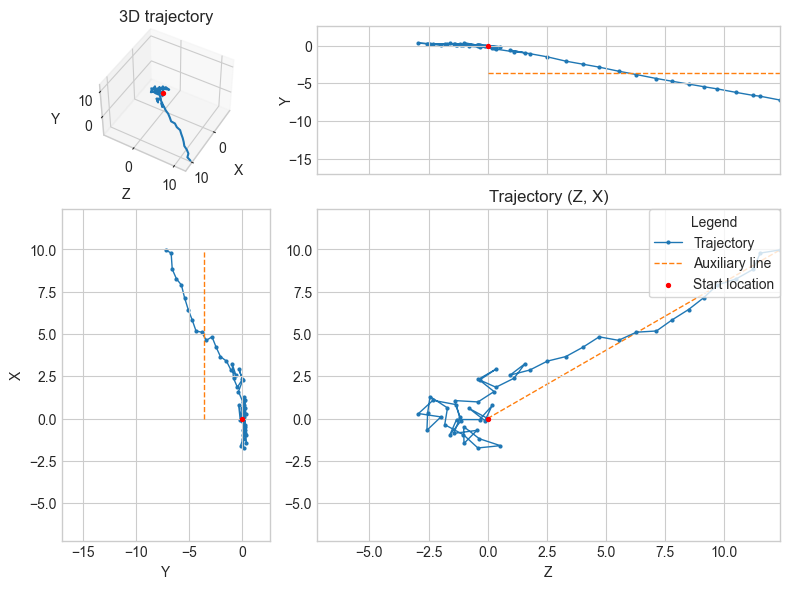

In [236]:
visualize_trajectory(trajectory)